In [1]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

import matplotlib.pyplot as plt 
import numpy as np
import rasterio
from torchvision.transforms import ToPILImage
from PIL import Image

In [2]:
# Load config file and get orthophoto data path
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
orthophoto_dir = config['data']['orthophotos']
predictions_dir = config['data']['segmentation_output']
nutzungsdaten_dir = config['data']['nutzungsdaten']

In [9]:
image_path = '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/orthophotos/patched/32698_5332_patch_3_3.tif'
image_path = '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/orthophotos/patched/32671_5358_patch_2_0.tif'

### Initialize Model and get predictions

In [4]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
import numpy as np
import rasterio

with rasterio.open(image_path) as src:
    image_np = src.read().transpose((1, 2, 0))  # Convert rasterio image to numpy array
    transform = src.transform  # Save georeferencing information
    crs = src.crs  # Save the Coordinate Reference System

    # Calculate midpoints for splitting
    h_mid = image_np.shape[0] // 2
    w_mid = image_np.shape[1] // 2

    # Split into 4 equal images
    image_1 = image_np[:h_mid, :w_mid, :3]
    image_2 = image_np[:h_mid, w_mid:, :3]
    image_3 = image_np[h_mid:, :w_mid, :3]
    image_4 = image_np[h_mid:, w_mid:, :3]

    images = [image_1, image_2, image_3, image_4]


    for i, image in enumerate(images):
        # Create a new rasterio dataset and write the image to a new tif file
        with rasterio.open(f'temp{i+1}.tif', 'w', driver='GTiff',
                           height=image.shape[0], width=image.shape[1],
                           count=3, dtype=image.dtype,
                           crs=crs, transform=transform) as dst:
            # Reorder the axes to rasterio order (bands, rows, columns)
            dst.write(image.transpose((2, 0, 1)))


In [11]:
sam.predict(image = 'temp1.tif', text_prompt='tree', box_threshold=0.24, text_threshold=0.24)  


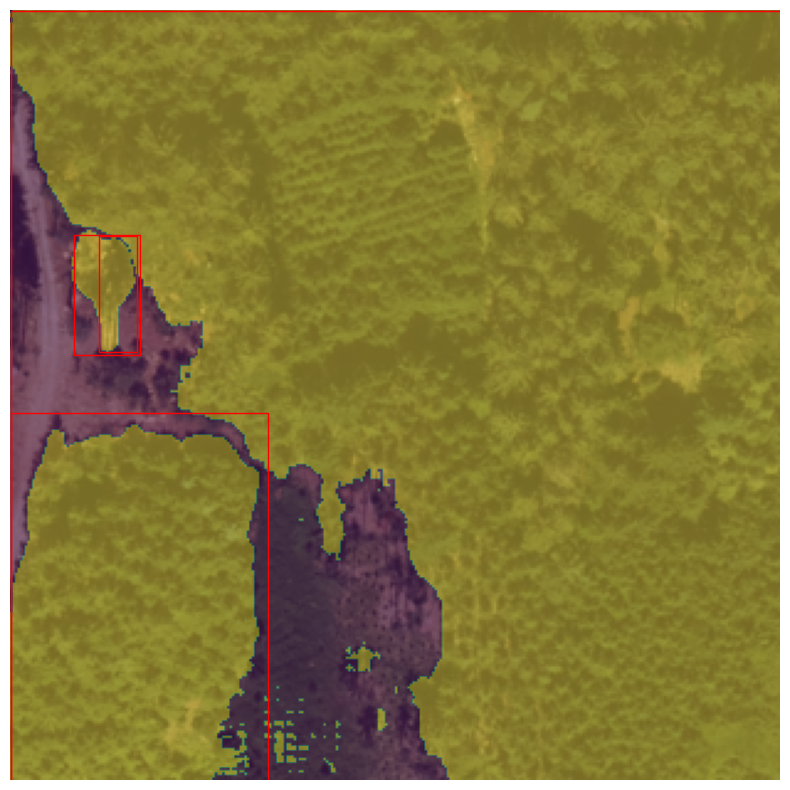

In [12]:
sam.show_anns()

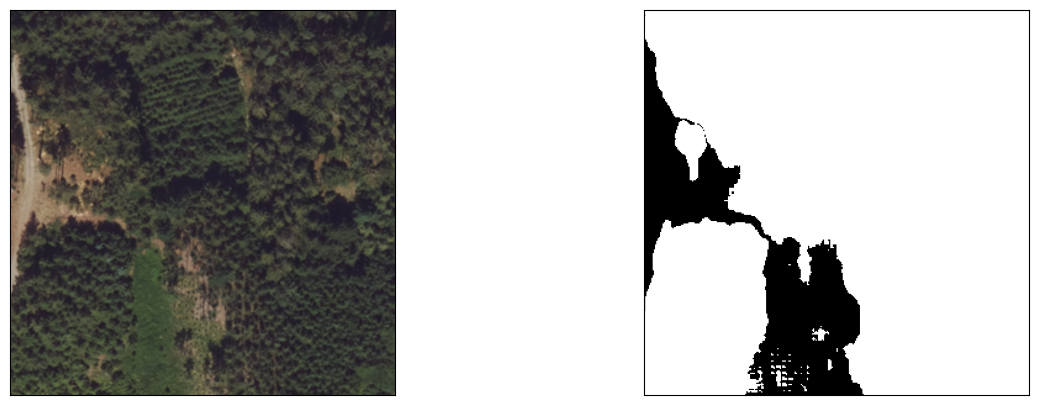

In [13]:
label = np.any(np.array(sam.masks), axis = 0).astype('int')

fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].imshow(sam.image.resize((800,800)))

ax[1].imshow(label, cmap='gray')
#ax[1].set_title('Prediction)

# Remove axes ticks
[ax[i].get_xaxis().set_ticks([]) for i in range(ax.shape[0])]
[ax[i].get_yaxis().set_ticks([]) for i in range(ax.shape[0])]
plt.show()